# Graph from queue simulation

## **1. Import libraries**

In [17]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

## **2. Read data**

In [ ]:
BASE_DIR = "../outputs/results_csv"
#BASE_DIR = "outputs/results_csv"

pattern = os.path.join(BASE_DIR, "workload_lambda_*", "per_node_rep", "*.csv")
files = glob.glob(pattern)
print("Found per_node_rep files:", len(files))

if not files:
    raise RuntimeError(f"No CSV files found. Check working dir and path:\n  {pattern}")

all_dfs = []
for f in files:
    df = pd.read_csv(f)
    # workload looks like "lam_25.0" -> extract 25.0
    df["lambda"] = df["workload"].str.extract(r"lam_(\d+(?:\.\d+)?)").astype(float)
    all_dfs.append(df)

data = pd.concat(all_dfs, ignore_index=True)
print("Columns:", data.columns.tolist())
display(data.head())

Found per_node_rep files: 90
Columns: ['workload', 'rep', 'seed', 'node_name', 'servers', 'mu', 'lambda_effective', 'E[w]', 'E[s]', 'E[r]', 'E[n_q]', 'E[n_s]', 'E[n]', 'utilization', 'num_completed_jobs', 'lambda']


,workload,rep,seed,node_name,servers,mu,lambda_effective,E[w],E[s],E[r],E[n_q],E[n_s],E[n],utilization,num_completed_jobs,lambda
0,lam_1.0,0,1000,registration,3,8.0,NaN,0.000000,0.120872,0.120872,0.000000,0.019027,0.019018,0.006342,2146,1.0
1,lam_1.0,0,1000,doctor,5,5.0,NaN,0.000000,0.204907,0.204907,0.000000,0.051667,0.051639,0.010333,2144,1.0
2,lam_1.0,0,1000,lab,4,10.0,NaN,0.000000,0.095331,0.095331,0.000000,0.000321,0.000321,0.000080,439,1.0
3,lam_1.0,0,1000,pharmacy,2,6.0,NaN,0.000604,0.161734,0.162338,0.000601,0.032735,0.033335,0.016367,2144,1.0
4,lam_1.0,1,1001,registration,3,8.0,NaN,0.000000,0.121434,0.121434,0.000000,0.021168,0.021168,0.007056,2247,1.0


## **3. Aggregate data**

In [19]:
metrics_to_avg = ["E[w]", "E[s]", "E[r]", "E[n_q]", "E[n_s]", "E[n]", "utilization"]

agg_df = (
    data
    .groupby(["lambda", "node_name"], as_index=False)[metrics_to_avg]
    .mean()
    .sort_values(["node_name", "lambda"])
)

print("Aggregated data:")
display(agg_df.head())

nodes = agg_df["node_name"].unique()

Aggregated data:


,lambda,node_name,E[w],E[s],E[r],E[n_q],E[n_s],E[n],utilization
0,1.0,doctor,0.000000e+00,0.200505,0.200505,0.000000e+00,0.053264,0.053255,0.010653
4,2.0,doctor,9.558916e-08,0.199039,0.199040,1.948107e-07,0.173267,0.173267,0.034653
8,3.0,doctor,1.669525e-05,0.199934,0.199950,5.130719e-05,0.324593,0.324644,0.064919
12,4.0,doctor,1.393327e-04,0.199468,0.199608,6.060849e-04,0.498568,0.499133,0.099714
16,5.0,doctor,1.680000e-04,0.201269,0.201433,8.886183e-04,0.700911,0.701780,0.140182


## **4. Figure 1: E[w], E[s], E[r]**

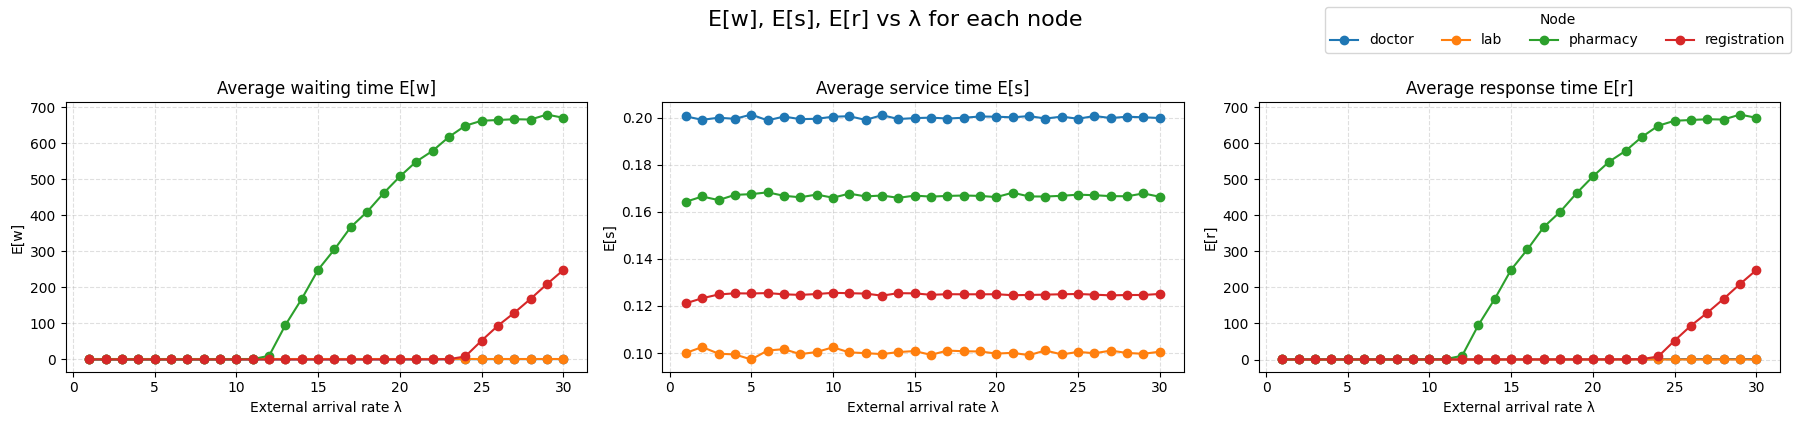

In [20]:
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 4), sharex=True)
metrics_1 = ["E[w]", "E[s]", "E[r]"]
titles_1 = ["Average waiting time E[w]",
            "Average service time E[s]",
            "Average response time E[r]"]

for ax, metric, title in zip(axes1, metrics_1, titles_1):
    for node in nodes:
        sub = agg_df[agg_df["node_name"] == node]
        ax.plot(sub["lambda"], sub[metric], marker="o", label=node)
    ax.set_title(title)
    ax.set_xlabel("External arrival rate λ")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle="--", alpha=0.4)

handles, labels = axes1[0].get_legend_handles_labels()
fig1.legend(handles, labels, title="Node", loc="upper right", ncol=len(nodes))
fig1.suptitle("E[w], E[s], E[r] vs λ for each node", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

## **4. Figure 2: E[n_q], E[n_s], E[n]**

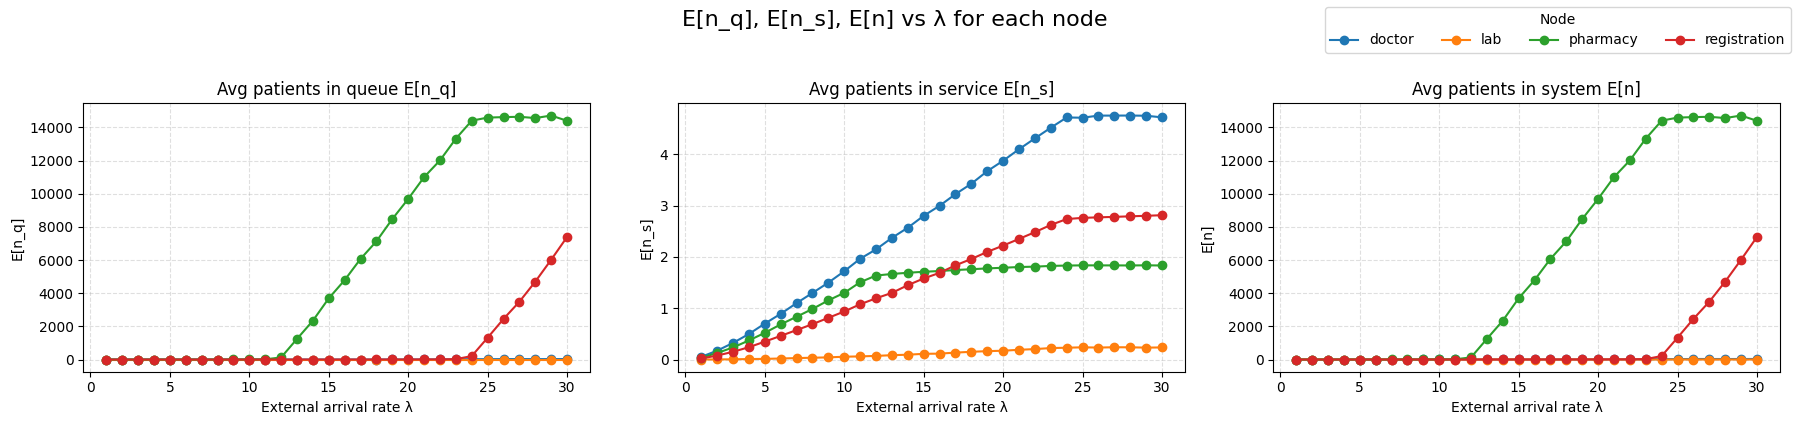

In [21]:
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 4), sharex=True)
metrics_2 = ["E[n_q]", "E[n_s]", "E[n]"]
titles_2 = ["Avg patients in queue E[n_q]",
            "Avg patients in service E[n_s]",
            "Avg patients in system E[n]"]

for ax, metric, title in zip(axes2, metrics_2, titles_2):
    for node in nodes:
        sub = agg_df[agg_df["node_name"] == node]
        ax.plot(sub["lambda"], sub[metric], marker="o", label=node)
    ax.set_title(title)
    ax.set_xlabel("External arrival rate λ")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle="--", alpha=0.4)

handles, labels = axes2[0].get_legend_handles_labels()
fig2.legend(handles, labels, title="Node", loc="upper right", ncol=len(nodes))
fig2.suptitle("E[n_q], E[n_s], E[n] vs λ for each node", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

## **5. Figure 3: Utilization**

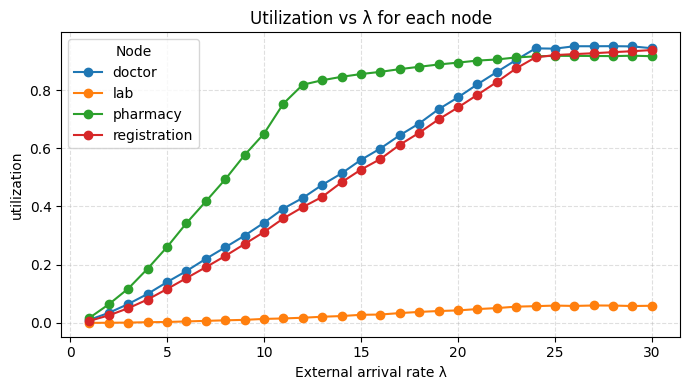

In [22]:
fig3, ax3 = plt.subplots(1, 1, figsize=(7, 4))

for node in nodes:
    sub = agg_df[agg_df["node_name"] == node]
    ax3.plot(sub["lambda"], sub["utilization"], marker="o", label=node)

ax3.set_title("Utilization vs λ for each node")
ax3.set_xlabel("External arrival rate λ")
ax3.set_ylabel("utilization")
ax3.grid(True, linestyle="--", alpha=0.4)
ax3.legend(title="Node")
plt.tight_layout()
plt.show()
